In [1]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import pearsonr
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics import mean_squared_error, r2_score


STEP 1: ESTIMATE PARAMETERS OF REAL DATA

a) use the same log_likelihood function to estimate the parametrs of each dataset we collected in the experiment. Here we also run the estimation process 10 times (with different initial guess) and we take the better esimation

In [2]:
def log_likelihood_realData(parameters, file_name):
    learning_rate, intercept, slope = parameters
    Prev_val = {'midLeft': 0.25, 'midRight': 0.25, 'downLeft': 0.25, 'downRight': 0.25}
    reward = {}
    
    df = pd.read_csv(file_name)
    df = df[(df['epoch'] != 'practice') & (df['key_resp.rt'].notna())].copy()

    log_likelihood = 0
      
    for i in range(len(df)):
        current_targetPos = df.iloc[i]['targetPos']
        current_frequency = df.iloc[i]['t_frequency']
        current_resp = df.iloc[i]['key_resp.corr']
        
        real_RT = df.iloc[i]['key_resp.rt']
        if real_RT <= 0 or pd.isna(real_RT):
            print("Not valid RT")
            continue  # salta valori non validi
        real_RS = 1 / real_RT

        # Compute reward
        for loc in Prev_val.keys():
            if current_resp == 1:
                if loc == current_targetPos and current_frequency == "high":
                    reward[loc] = 100
                elif loc == current_targetPos and current_frequency != "high":
                    reward[loc] = 1
                else:
                    reward[loc] = 0
            elif current_resp == 0:
                reward[loc] = 0

        #calculate RS
        predicted_RS = intercept + slope * Prev_val[current_targetPos] 
        error = real_RS - predicted_RS
        log_likelihood += -error ** 2 

        # Update probabilities
        for loc in Prev_val.keys():
            Prev_val[loc] += learning_rate * (reward[loc] - Prev_val[loc])
            Prev_val[loc] = min(max(Prev_val[loc], 0.0001), 0.9999) 
            
        total = sum(Prev_val.values())
        for loc in Prev_val.keys():
            Prev_val[loc] /= total
        
    return -log_likelihood 

In [3]:
data_dir = "C:\\Users\\cdolci\\Desktop\\Data\\RL\\"
file_pattern = os.path.join(data_dir, "*_RewSL_RL_EEG_*.csv")
#List participants
participant_files = glob.glob(file_pattern)

In [4]:
#List where I can store the estimated parametrs
participant_ids = []
estimated_learning_rate = []
estimated_intercept = []
estimated_slope = []

for file in participant_files:
    data = pd.read_csv(file)
    #extract participant's number
    if "participant" in data.columns:
        participant_id = data["participant"].iloc[0]  
    else:
        print(f"Skipping {file}: 'participant' column not found.")
        continue
    
    best_result = None
    best_log_likelihood = float('inf')
    #try the parameter estimation 10 times
    print(f"Start {file}: 'participant'")
    
    for _ in range(5):  
        random_init_params = [
            np.random.uniform(0.1, 0.9),  #Learning rate
            np.random.uniform(0.1, 10),   #Intercept
            np.random.uniform(0.1, 10)       #Slope
        ]
    
        result = minimize(log_likelihood_realData,random_init_params,args=(file,), bounds=[(0,1), (-100, 100), (-100, 100)])

        if result.success and result.fun < best_log_likelihood:
            best_log_likelihood = result.fun
            best_result = result

    #Store best results
    participant_ids.append(participant_id)

    if best_result:
        estimated_learning_rate.append(best_result.x[0])
        estimated_intercept.append(best_result.x[1])
        estimated_slope.append(best_result.x[2])
    else:
        estimated_learning_rate.append(np.nan)
        estimated_intercept.append(np.nan)
        estimated_slope.append(np.nan)
        print(f"Optimization failed for participant {participant_id}")

#Creazte DataFrame with results
results_df = pd.DataFrame({
    "Participant_ID": participant_ids,
    "Learning_Rate": estimated_learning_rate,
    "Intercept": estimated_intercept,
    "Slope": estimated_slope
})

results_df.to_csv("RL_RealData_estimated_parameters.csv", index=False)
print("Estimation complete. Results saved in 'RealData_estimated_parameters.csv'.")

Start C:\Users\cdolci\Desktop\Data\RL\10_RewSL_RL_EEG_1.csv: 'participant'
Start C:\Users\cdolci\Desktop\Data\RL\11_RewSL_RL_EEG_2.csv: 'participant'
Start C:\Users\cdolci\Desktop\Data\RL\12_RewSL_RL_EEG_2.csv: 'participant'
Start C:\Users\cdolci\Desktop\Data\RL\1_RewSL_RL_EEG_1.csv: 'participant'
Start C:\Users\cdolci\Desktop\Data\RL\2_RewSL_RL_EEG_1.csv: 'participant'
Start C:\Users\cdolci\Desktop\Data\RL\3_RewSL_RL_EEG_1.csv: 'participant'
Start C:\Users\cdolci\Desktop\Data\RL\4_RewSL_RL_EEG_1.csv: 'participant'
Start C:\Users\cdolci\Desktop\Data\RL\5_RewSL_RL_EEG_1.csv: 'participant'
Start C:\Users\cdolci\Desktop\Data\RL\6_RewSL_RL_EEG_1.csv: 'participant'
Start C:\Users\cdolci\Desktop\Data\RL\7_RewSL_RL_EEG_1.csv: 'participant'
Start C:\Users\cdolci\Desktop\Data\RL\8_RewSL_RL_EEG_1.csv: 'participant'
Start C:\Users\cdolci\Desktop\Data\RL\9_RewSL_RL_EEG_1.csv: 'participant'
Estimation complete. Results saved in 'RealData_estimated_parameters.csv'.


STEP 3: SIMULATE RT ON REAL DATASET BY USING THE PARAMETRS WE ESTIMATED 

In [5]:
def simulate_RS(parameters, file_name): 
    learning_rate, intercept, slope = parameters
    noise_std=0.1
    Prev_val = {'midLeft': 0.25, 'midRight': 0.25, 'downLeft': 0.25, 'downRight': 0.25}
    reward = {}
    df = pd.read_csv(file_name)
    df = df[(df['epoch'] != 'practice') & (df['key_resp.rt'].notna())].copy()
    
    # Lists to collect trial-wise values
    simulated_RS = []
    real_RS = []
    prob_midLeft, prob_midRight, prob_downLeft, prob_downRight = [], [], [], []
    reward_midLeft, reward_midRight, reward_downLeft, reward_downRight = [], [], [], []
    prob_high, prob_lowA, prob_lowB, prob_lowC = [], [], [], []

    for i in range(len(df)):
        current_targetPos = df.iloc[i]['targetPos']
        current_frequency = df.iloc[i]['t_frequency']
        current_resp = df.iloc[i]['key_resp.corr']

        real_RT = df.iloc[i]['key_resp.rt']
        if real_RT <= 0:
            real_RS_val = np.nan
            print("Something wrong. RT = 0")
        else:
            real_RS_val = 1 / real_RT
        real_RS.append(real_RS_val)

        #Compute outcomes
        for loc in Prev_val.keys():
            if current_resp == 1:
                if loc == current_targetPos and current_frequency == "high":
                    reward[loc] = 100
                elif loc == current_targetPos and current_frequency != "high":
                    reward[loc] = 1
                else:
                    reward[loc] = 0
            elif current_resp == 0:
                reward[loc] = 0

        #Store current probabilities
        prob_midLeft.append(Prev_val['midLeft'])
        prob_midRight.append(Prev_val['midRight'])
        prob_downLeft.append(Prev_val['downLeft'])
        prob_downRight.append(Prev_val['downRight'])

        #Store outcomes
        reward_midLeft.append(reward['midLeft'])
        reward_midRight.append(reward['midRight'])
        reward_downLeft.append(reward['downLeft'])
        reward_downRight.append(reward['downRight'])

        #map probability for each target frequency
        if df.iloc[i]['Rlblock'] == 1:
            prob_high_val = Prev_val['midLeft']
            prob_lowA_val = Prev_val['midRight']
            prob_lowB_val = Prev_val['downLeft']
            prob_lowC_val = Prev_val['downRight'] 
        elif df.iloc[i]['Rlblock'] == 2:
            prob_high_val = Prev_val['midRight']
            prob_lowA_val = Prev_val['midLeft']
            prob_lowB_val = Prev_val['downRight']
            prob_lowC_val = Prev_val['downLeft'] 
        elif df.iloc[i]['Rlblock'] == 3:
            prob_high_val = Prev_val['downLeft']
            prob_lowA_val = Prev_val['downRight']
            prob_lowB_val = Prev_val['midLeft']
            prob_lowC_val = Prev_val['midRight']
        elif df.iloc[i]['Rlblock'] == 4:
            prob_high_val = Prev_val['downRight']
            prob_lowA_val = Prev_val['downLeft']
            prob_lowB_val = Prev_val['midRight']
            prob_lowC_val = Prev_val['midLeft']

        #Store probabilities by frequency
        prob_high.append(prob_high_val)
        prob_lowA.append(prob_lowA_val)
        prob_lowB.append(prob_lowB_val)
        prob_lowC.append(prob_lowC_val)

        #Predict RS 
        predict_RS = intercept + slope * Prev_val[current_targetPos] + np.random.normal(0, noise_std)
        simulated_RS.append(predict_RS)

        #Update probabilities
        for loc in Prev_val.keys():
            Prev_val[loc] += learning_rate * (reward[loc] - Prev_val[loc])
            Prev_val[loc] = min(max(Prev_val[loc], 0.0001), 0.9999) 
            
        total = sum(Prev_val.values())
        for loc in Prev_val.keys():
            Prev_val[loc] /= total

    # Add columns to dataframe
    df['simulated_RS'] = simulated_RS
    df['real_RS'] = real_RS

    df['prev_val_midLeft'] = prob_midLeft
    df['prev_val_midRight'] = prob_midRight
    df['prev_val_downLeft'] = prob_downLeft
    df['prev_val_downRight'] = prob_downRight

    df['reward_midLeft'] = reward_midLeft
    df['reward_midRight'] = reward_midRight
    df['reward_downLeft'] = reward_downLeft
    df['reward_downRight'] = reward_downRight

    df['prev_val_high'] = prob_high
    df['prev_val_lowA'] = prob_lowA
    df['prev_val_lowB'] = prob_lowB
    df['prev_val_lowC'] = prob_lowC

    return df

In [6]:
params_df = pd.read_csv("RL_RealData_estimated_parameters.csv")

# Simulate for all participants
all_simulated_data = []

for file in participant_files:
    data = pd.read_csv(file)
    participant_id = data["participant"].iloc[0]

    # Get their parameters
    row = params_df[params_df["Participant_ID"] == participant_id]
    if row.empty:
        continue

    #intercept = row["Intercept"].values[0]
    #slope = row["Slope"].values[0]
    #fixed_learning_rate = 0.3
    #params = [fixed_learning_rate, intercept, slope]
    params = row[["Learning_Rate", "Intercept", "Slope"]].values.flatten()
    print(f"Participant {participant_id} - Learning Rate: {params[0]:.4f}, Intercept: {params[1]:.4f}, Slope: {params[2]:.4f}")
    simulated_df = simulate_RS(params, file)
    simulated_df['Participant_ID'] = participant_id
    all_simulated_data.append(simulated_df)

# Concatenate all
final_simulated_df = pd.concat(all_simulated_data, ignore_index=True)
final_simulated_df.to_csv("RL_simulated_RS_all_participants.csv", index=False)

Participant 10 - Learning Rate: 0.1077, Intercept: 1.2964, Slope: 0.2972
Participant 11 - Learning Rate: 0.4026, Intercept: 1.3692, Slope: 0.2113
Participant 12 - Learning Rate: 0.1144, Intercept: 1.9497, Slope: 0.1822
Participant 1 - Learning Rate: 0.2645, Intercept: 1.6681, Slope: 0.1341
Participant 2.0 - Learning Rate: 0.5575, Intercept: 1.3241, Slope: 0.1758
Participant 3 - Learning Rate: 0.4021, Intercept: 1.1887, Slope: 0.1229
Participant 4 - Learning Rate: 0.4386, Intercept: 2.0100, Slope: 0.1791
Participant 5 - Learning Rate: 0.4875, Intercept: 1.1439, Slope: 0.0589
Participant 6 - Learning Rate: 0.4978, Intercept: 1.4266, Slope: 0.2350
Participant 7 - Learning Rate: 0.0545, Intercept: 1.5168, Slope: 0.2738
Participant 8 - Learning Rate: 0.1987, Intercept: 1.4451, Slope: 0.2774
Participant 9 - Learning Rate: 0.3028, Intercept: 1.3695, Slope: 0.2297


In [7]:
simulated_df = pd.read_csv("RL_simulated_RS_all_participants.csv")
participants = simulated_df['Participant_ID'].unique()

# Loop through each participant
for participant in participants:
    subset = simulated_df[simulated_df['Participant_ID'] == participant].copy()
    subset.reset_index(drop=True, inplace=True)

    sim_std = subset["simulated_RS"].std()
    real_std = subset["real_RS"].std()

    print(f"Participant {participant} → Simulated RS std: {sim_std:.4f}, Real RS std: {real_std:.4f}")

Participant 10.0 → Simulated RS std: 0.1201, Real RS std: 0.3173
Participant 11.0 → Simulated RS std: 0.1135, Real RS std: 0.2444
Participant 12.0 → Simulated RS std: 0.1049, Real RS std: 0.9210
Participant 1.0 → Simulated RS std: 0.1054, Real RS std: 0.2590
Participant 2.0 → Simulated RS std: 0.1180, Real RS std: 0.2891
Participant 3.0 → Simulated RS std: 0.1024, Real RS std: 0.2454
Participant 4.0 → Simulated RS std: 0.1092, Real RS std: 0.4493
Participant 5.0 → Simulated RS std: 0.1029, Real RS std: 0.2654
Participant 6.0 → Simulated RS std: 0.1202, Real RS std: 1.1072
Participant 7.0 → Simulated RS std: 0.1223, Real RS std: 0.3300
Participant 8.0 → Simulated RS std: 0.1131, Real RS std: 0.3341
Participant 9.0 → Simulated RS std: 0.1108, Real RS std: 0.2827


In [11]:
simulated_df = pd.read_csv("RL_simulated_RS_all_participants.csv")
participants = simulated_df['Participant_ID'].unique()

def compute_corr(df):
    r, p = pearsonr(df['real_RS'], df['simulated_RS'])
    return pd.Series({'pearson_r': r, 'p_value': p})

# Apply without including grouping column in the group data
correlations = simulated_df.groupby('Participant_ID', group_keys=False).apply(compute_corr).reset_index()

# Print results
for _, row in correlations.iterrows():
    print(f"Participant {int(row['Participant_ID'])}: r = {row['pearson_r']:.2f}, p = {row['p_value']:.4f}")

Participant 1: r = 0.04, p = 0.1447
Participant 2: r = 0.07, p = 0.0459
Participant 3: r = 0.01, p = 0.6715
Participant 4: r = 0.01, p = 0.6508
Participant 5: r = -0.04, p = 0.1778
Participant 6: r = 0.01, p = 0.6906
Participant 7: r = 0.09, p = 0.0023
Participant 8: r = 0.06, p = 0.0425
Participant 9: r = 0.08, p = 0.0066
Participant 10: r = 0.12, p = 0.0001
Participant 11: r = 0.09, p = 0.0022
Participant 12: r = 0.01, p = 0.6973


C:\Users\cdolci\AppData\Local\Temp\ipykernel_20312\2626273292.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations = simulated_df.groupby('Participant_ID', group_keys=False).apply(compute_corr).reset_index()


b) plot the real vs simulated RT to see if they were well simulated

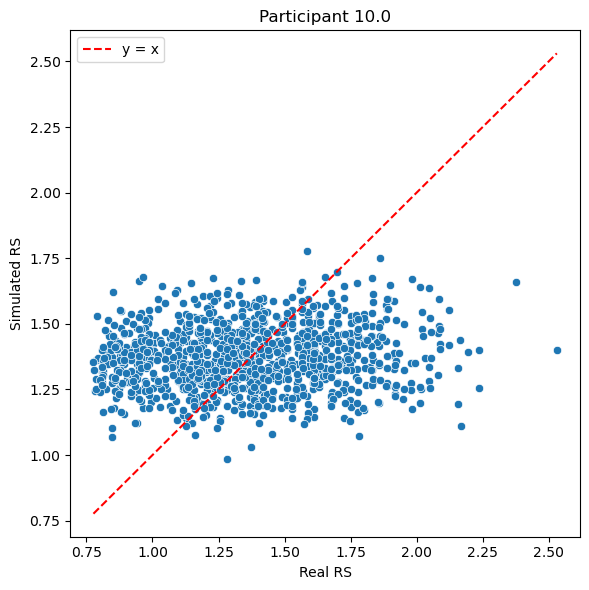

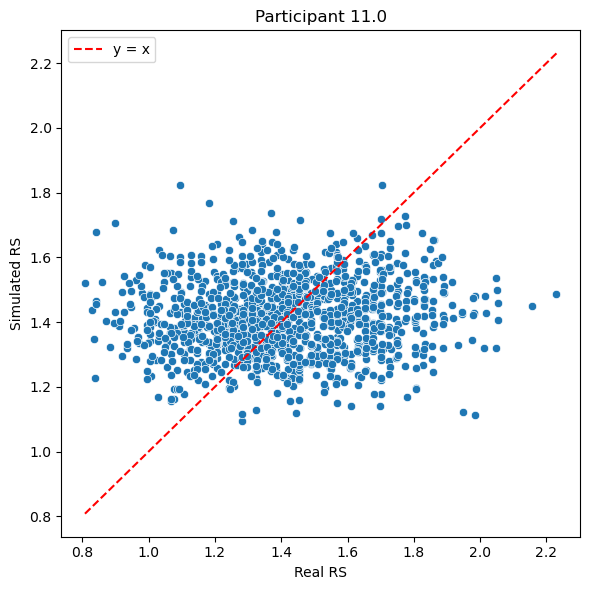

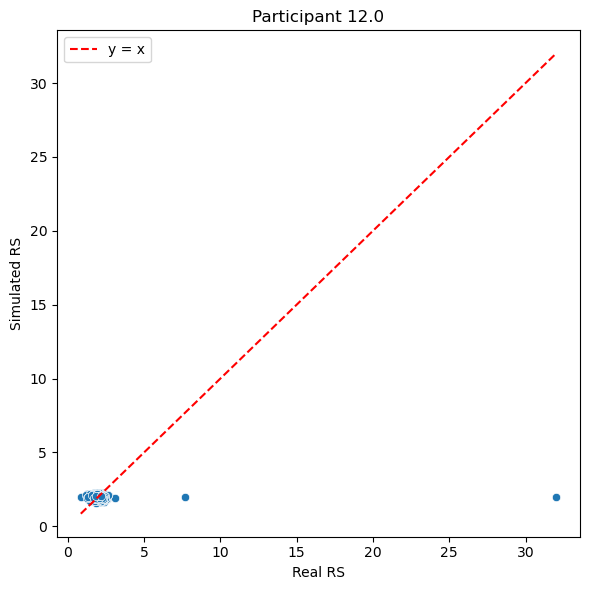

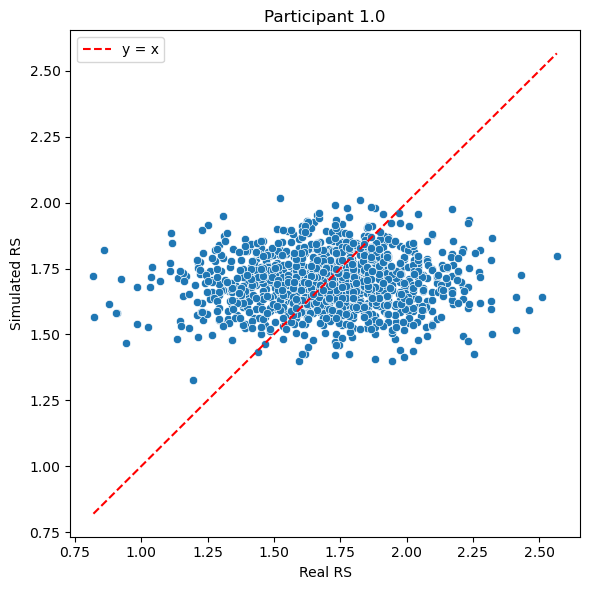

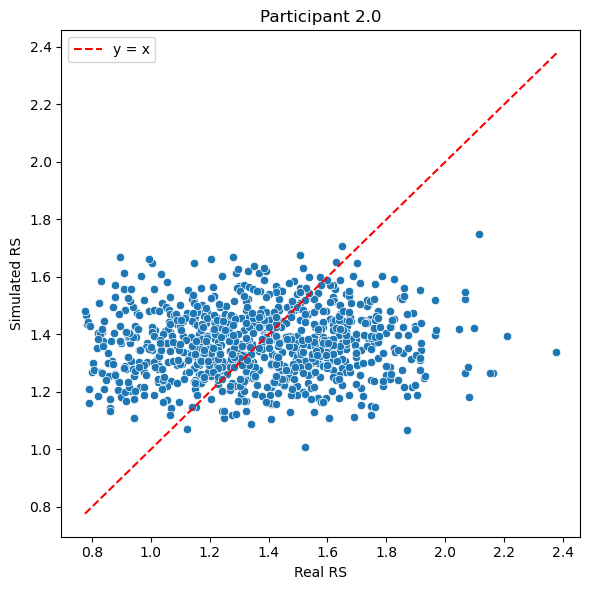

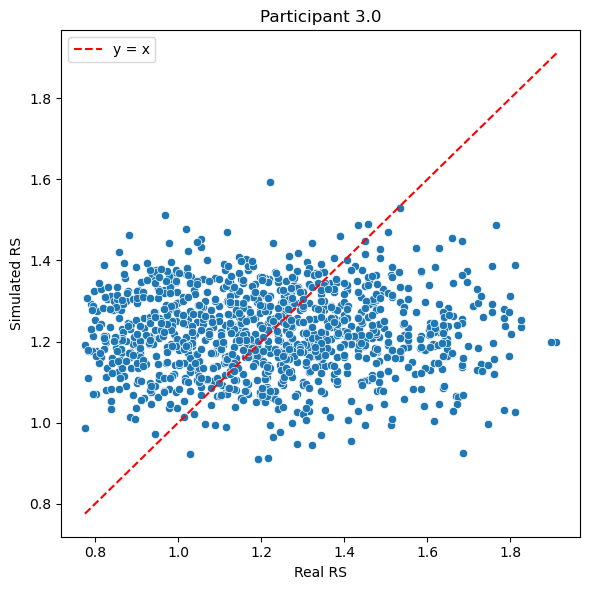

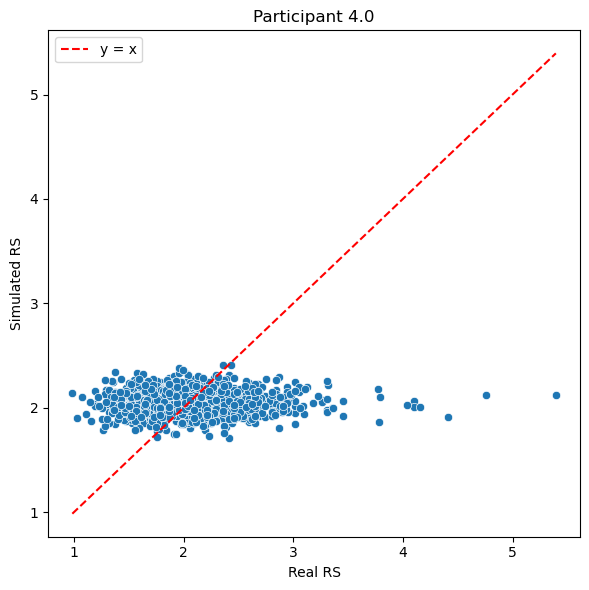

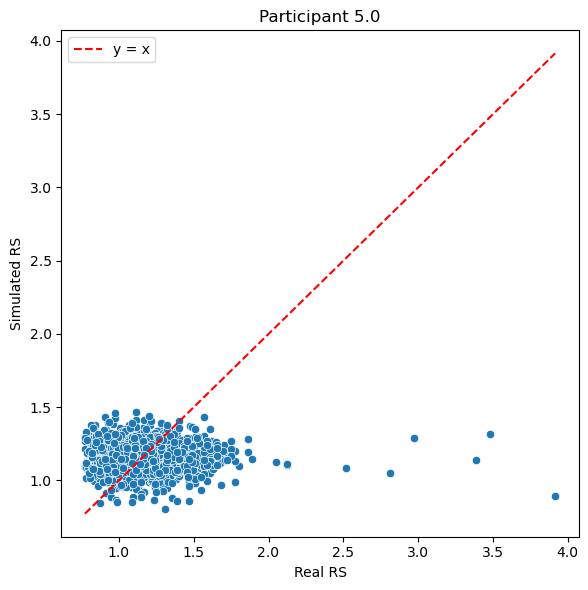

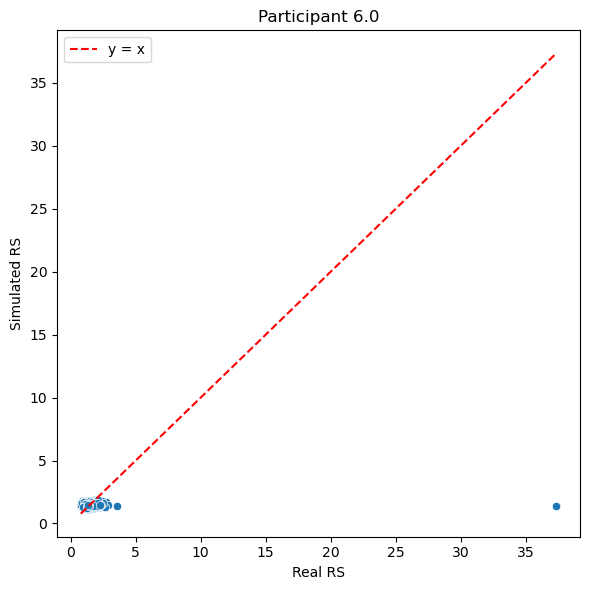

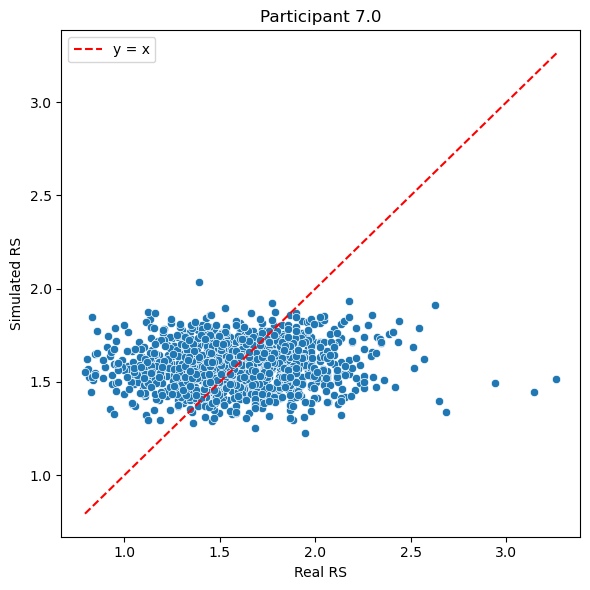

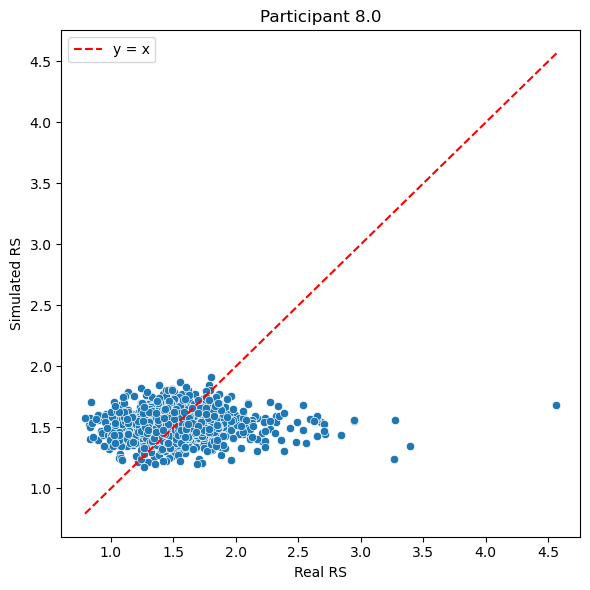

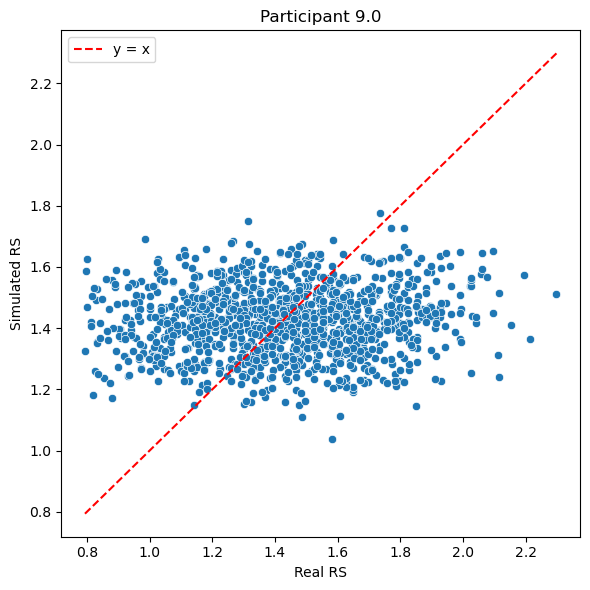

In [9]:
simulated_df = pd.read_csv("RL_simulated_RS_all_participants.csv")
participants = simulated_df['Participant_ID'].unique()

# Loop through each participant
for participant in participants:
    subset = simulated_df[simulated_df['Participant_ID'] == participant].copy()
    subset.reset_index(drop=True, inplace=True)

    plt.figure(figsize=(6, 6))
    sns.scatterplot(data=subset, x='real_RS', y='simulated_RS')

    # Diagonal reference line (y = x)
    min_val = min(subset['real_RS'].min(), subset['simulated_RS'].min())
    max_val = max(subset['real_RS'].max(), subset['simulated_RS'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')

    plt.xlabel('Real RS')
    plt.ylabel('Simulated RS')
    plt.title(f'Participant {participant}')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
simulated_df = pd.read_csv("RL_simulated_RS_all_participants.csv")
participants = simulated_df['Participant_ID'].unique()

#Loop through each participant
for participant in participants:
    subset = simulated_df[simulated_df['Participant_ID'] == participant].copy()

    #Group by trial number within block and compute means
    grouped = subset.groupby('trials_e.thisN')[['real_RS', 'simulated_RS']].mean().reset_index()

    #Plot
    plt.figure(figsize=(6, 6))
    sns.scatterplot(data=grouped, x='real_RS', y='simulated_RS')

    # Diagonal reference line (y = x)
    min_val = min(grouped['real_RS'].min(), grouped['simulated_RS'].min())
    max_val = max(grouped['real_RS'].max(), grouped['simulated_RS'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')

    plt.xlabel('Mean Real RS (per trial index)')
    plt.ylabel('Mean Simulated RS (per trial index)')
    plt.title(f'Participant {participant}')
    plt.legend()
    plt.tight_layout()
    plt.show()

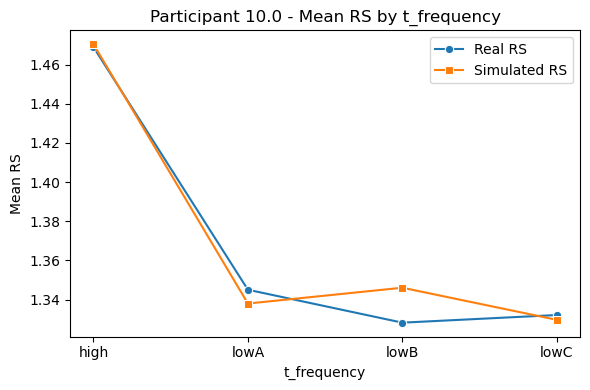

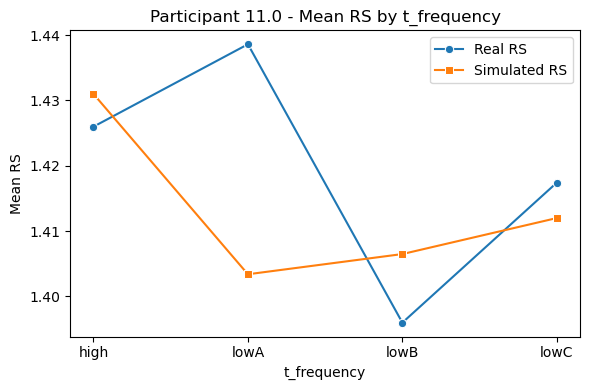

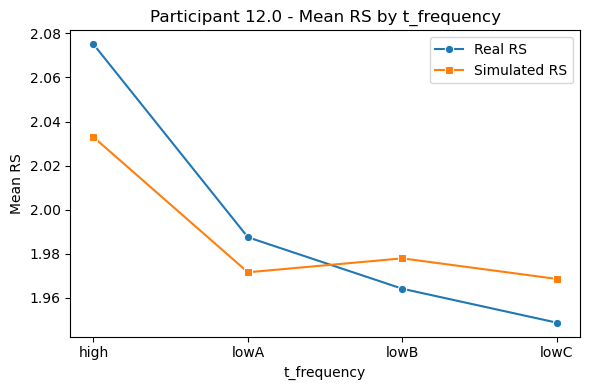

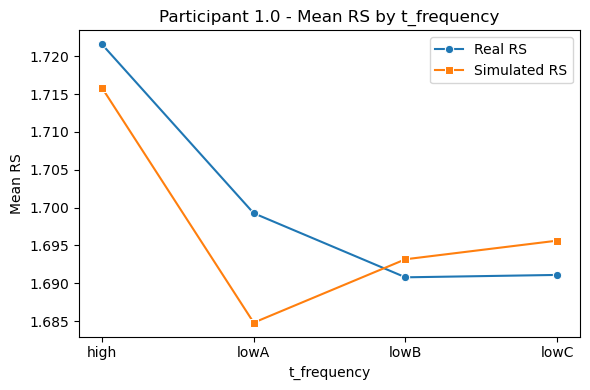

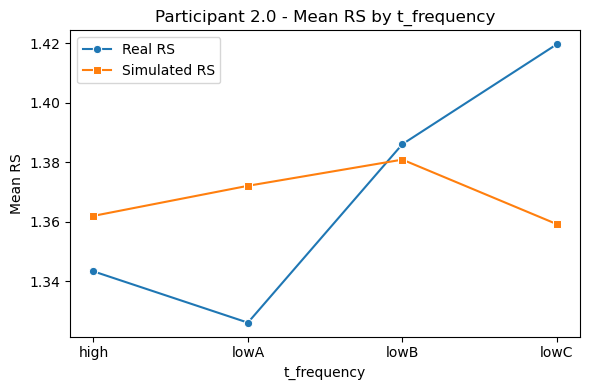

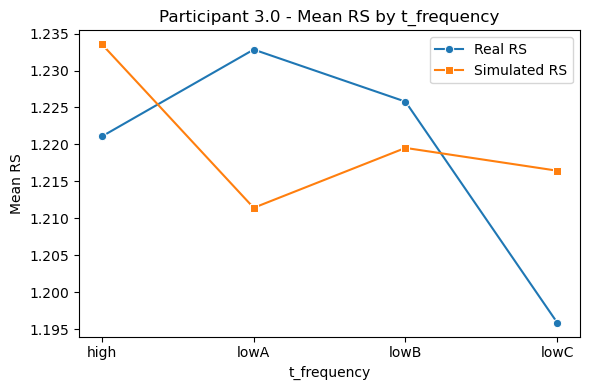

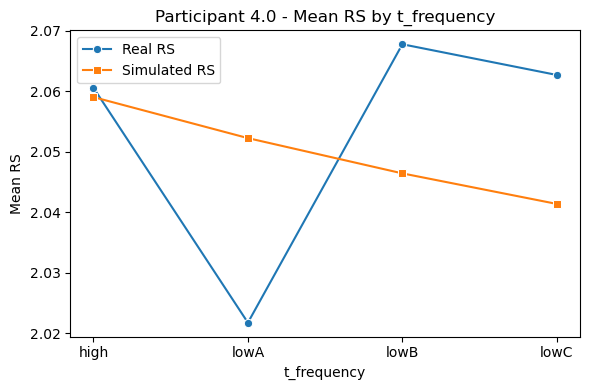

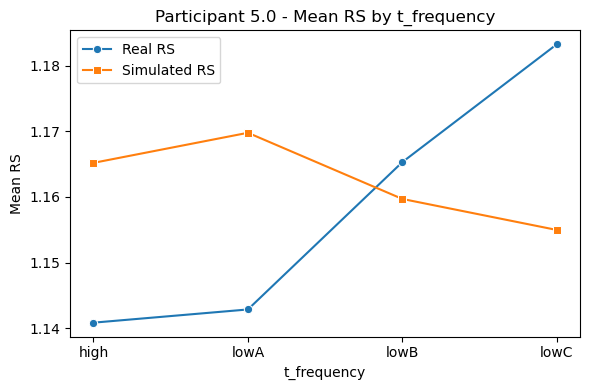

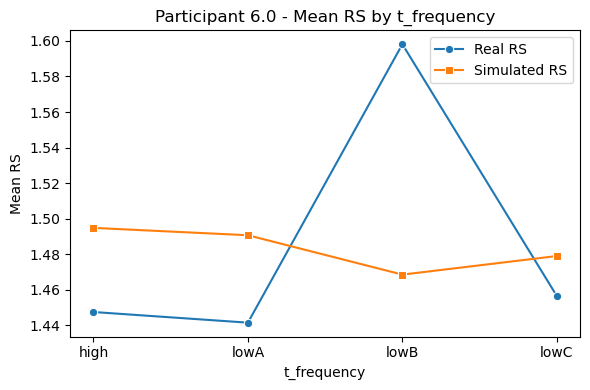

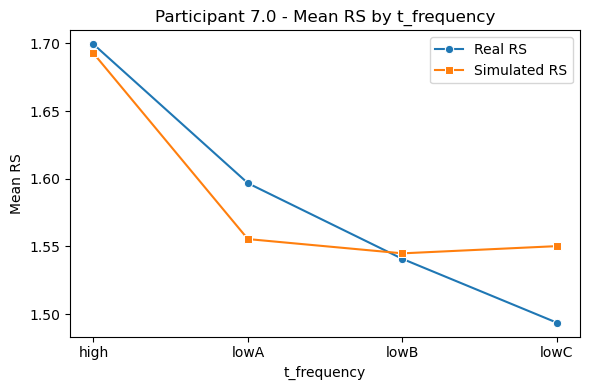

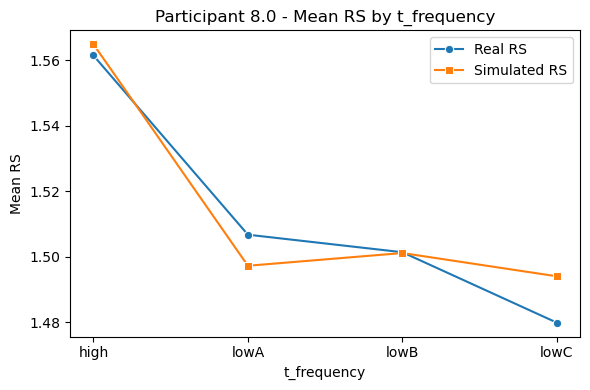

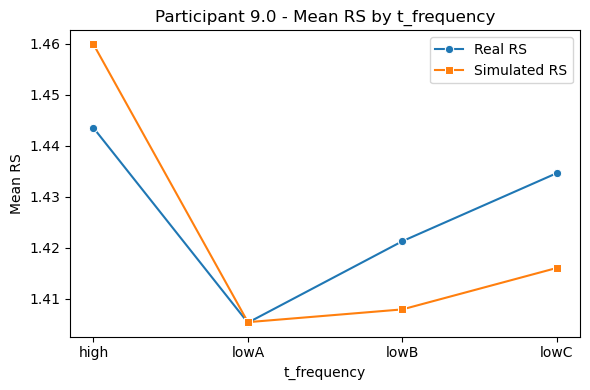

In [12]:
simulated_df = simulated_df.dropna(subset=['real_RS'])

# Get unique participant IDs
participants = simulated_df['Participant_ID'].unique()

# Loop through each participant
for participant in participants:
    # Filter data for the current participant
    subset = simulated_df[simulated_df['Participant_ID'] == participant]
    
    # Group by condition and compute mean RS values
    mean_rts = subset.groupby('t_frequency').agg(
        real_RS=('real_RS', 'mean'),
        simulated_RS=('simulated_RS', 'mean')
    ).reset_index()
    
    # Plot
    plt.figure(figsize=(6, 4))
    sns.lineplot(data=mean_rts, x='t_frequency', y='real_RS', label='Real RS', marker='o')
    sns.lineplot(data=mean_rts, x='t_frequency', y='simulated_RS', label='Simulated RS', marker='s')
    
    plt.title(f'Participant {participant} - Mean RS by t_frequency')
    plt.xlabel('t_frequency')
    plt.ylabel('Mean RS')
    plt.legend()
    plt.tight_layout()
    plt.show()